**To keep in mind:**

O. Okike, J. A. Alhassan, E. U. Iyida and A. E. Chukwude. A comparison of catalogues of Forbush decreases identified from individual and a network of neutron monitors: a critical perspective. MNRAS 503, 5675–5691 (2021) doi:10.1093/mnras/stab680.  

For the purpose of a comparative study of two FD catalogues and subsequent analysis: 
- The FD catalogue of the Russian investigators (Belov et al. 2018a) was downloaded from http://spaceweather.izmiran.ru/eng/dbs.html. It is the most comprehensive and up to date Forbush event catalogue. Several CR investigators have employed the catalogue. Some of the publications based on the IZMIRAN FD list are displayed at http://spaceweather.izmiran.ru/eng/papers.html. Belov (2008) asserts that the list is more accurate, as it was selected using several CR physical characteristics (e.g. density and anisotropy).
- The FD catalogue of Lockwood is sourced from https://ngdc.noaa.gov/stp/space-weather/interplanetary-data/cosmic-rays/forbush-decreases/. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("DataStudy.csv")
df["DATETIME"]=pd.to_datetime(df["DATETIME"])
df["DATETIME"] = df["DATETIME"].dt.tz_convert(None)  # drop timezone
df.set_index("DATETIME",inplace=True)

In [3]:
df

,MXCO,JUNG1,LMKS,KERG,OULU
DATETIME,,,,,
2019-01-01 00:00:00,228.125,378.839,467.935,236.684,108.320
2019-01-01 00:02:00,232.292,383.348,464.054,242.002,110.534
2019-01-01 00:04:00,228.600,387.431,468.508,240.182,112.859
2019-01-01 00:06:00,228.833,377.736,470.842,235.399,110.825
2019-01-01 00:08:00,228.317,375.393,470.691,236.534,111.250
...,...,...,...,...,...
2025-11-15 17:20:00,NaN,322.236,368.720,186.365,88.487
2025-11-15 17:22:00,NaN,321.239,363.016,188.282,90.513
2025-11-15 17:24:00,NaN,323.701,364.111,182.680,87.884


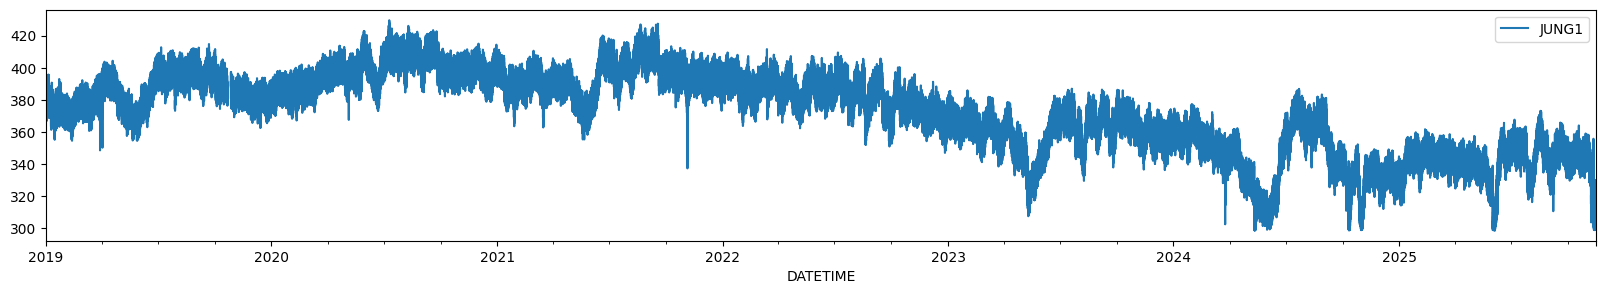

In [4]:
df["JUNG1"].plot(figsize=(20,3))
plt.legend();plt.show()

## Core helper functions (single station panel)

In [5]:
import math
import numpy as np
import pandas as pd


# ---------- Background + deltaN ----------

def make_deltaN(df, station, bg_window_hours=72):
    """
    Build a panel for one station with:
      - counts
      - counts_clean (spikes removed)
      - bg (robust background)
      - deltaN (% deviation from bg)
    """
    series = df[station].astype(float)

    # Remove insane spikes (very crude, just to avoid catastrophes)
    med = series.median()
    mad = (series - med).abs().median()
    clean = series.mask((series - med).abs() > 6 * mad)

    # Time step and background window
    dt_minutes = (df.index[1] - df.index[0]).total_seconds() / 60.0
    pts_per_hour = int(round(60.0 / dt_minutes))
    bg_window = int(bg_window_hours * pts_per_hour)

    bg = clean.rolling(window=bg_window,
                       center=True,
                       min_periods=int(0.5 * bg_window)).median()

    deltaN = 100.0 * (clean - bg) / bg

    out = pd.DataFrame({
        "counts": series,
        "counts_clean": clean,
        "bg": bg,
        "deltaN": deltaN
    })

    return out


# ---------- Complexity measures ----------

def permutation_entropy(x, m=3, delay=1):
    """
    Normalized permutation entropy in [0, 1].
    x: 1D array-like
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < m * delay:
        return np.nan

    patterns = []
    for i in range(n - (m - 1) * delay):
        window = x[i:i + m * delay:delay]
        ranks = np.argsort(window)
        patterns.append(tuple(ranks))

    if len(patterns) == 0:
        return np.nan

    patterns = np.array(patterns, dtype=object)
    _, counts = np.unique(patterns, return_counts=True)
    probs = counts / counts.sum()

    pe = -np.sum(probs * np.log(probs))
    pe_norm = pe / math.log(math.factorial(m))

    return pe_norm


def katz_fd(x):
    """
    Katz fractal dimension for a 1D series.
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        return np.nan

    diffs = np.diff(x)
    L = np.sum(np.sqrt(1.0 + diffs**2))

    t = np.arange(n, dtype=float)
    dists = np.sqrt((t - t[0])**2 + (x - x[0])**2)
    d = np.max(dists)

    if d == 0 or L == 0:
        return np.nan

    return math.log10(n) / (math.log10(n) + math.log10(d / L))


def compute_complexity_panel(st_df, window_hours=3, m=3, delay=1):
    """
    Add PE and KFD in a sliding window over 'counts_clean'.
    """
    dt_minutes = (st_df.index[1] - st_df.index[0]).total_seconds() / 60.0
    pts_per_hour = int(round(60.0 / dt_minutes))
    win = int(window_hours * pts_per_hour)

    roll = st_df["counts_clean"].rolling(window=win,
                                         min_periods=int(0.5 * win))

    pe = roll.apply(lambda x: permutation_entropy(x, m=m, delay=delay),
                    raw=True)
    kfd = roll.apply(lambda x: katz_fd(x),
                     raw=True)

    out = st_df.copy()
    out["PE"] = pe
    out["KFD"] = kfd

    return out


# ---------- Robust normalization ----------

def robust_z(series, ref_mask):
    """
    Robust z-score (median / MAD) over a reference subset.
    """
    ref = series[ref_mask].dropna()
    med = ref.median()
    mad = (ref - med).abs().median()

    if mad == 0 or np.isnan(mad):
        return pd.Series(np.nan, index=series.index)

    return (series - med) / mad


def add_complexity_scores(st_panel,
                          quiet_start="2019-01-15",
                          quiet_end="2019-03-15"):
    """
    Add z_PE, z_KFD and A_complex to a station panel.
    """
    panel = st_panel.copy()
    ref_mask = (panel.index >= quiet_start) & (panel.index < quiet_end)

    panel["z_PE"] = robust_z(panel["PE"], ref_mask)
    panel["z_KFD"] = robust_z(panel["KFD"], ref_mask)

    panel["A_complex"] = panel[["z_PE", "z_KFD"]].abs().max(axis=1)

    return panel

## Sierra FD detector (single station, clean station name)

In [6]:
def detect_fd_events(
    station_df,
    a_thresh=3.0,
    min_a_duration_hours=3.0,
    min_drop_percent=2.0,
    max_time_to_min_hours=48.0,
    recovery_fraction=0.5,
    max_recovery_days=7.0,
    bg_lookback_hours=24.0
):
    """
    Sierra FD detector for a single station:
      - station_df must have columns: deltaN, A_complex
      - and a regular DateTimeIndex (naive or tz-aware, both OK).
    """
    df = station_df.copy()

    if "deltaN" not in df.columns or "A_complex" not in df.columns:
        raise ValueError("station_df must have 'deltaN' and 'A_complex'")

    # time step
    dt_minutes = (df.index[1] - df.index[0]).total_seconds() / 60.0
    pts_per_hour = max(int(round(60.0 / dt_minutes)), 1)

    min_a_pts        = int(round(min_a_duration_hours * pts_per_hour))
    max_to_min_pts   = int(round(max_time_to_min_hours * pts_per_hour))
    max_recovery_pts = int(round(max_recovery_days * 24.0 * pts_per_hour))
    bg_lookback_pts  = int(round(bg_lookback_hours * pts_per_hour))

    high_a = df["A_complex"] > a_thresh
    events = []

    if not high_a.any():
        return pd.DataFrame(columns=[
            "station", "onset_time", "min_time", "rec_time",
            "drop_percent", "A_complex_max", "bg_level_pre"
        ])

    idx = np.where(high_a.values)[0]

    # group contiguous indices into segments
    segments = []
    start = idx[0]
    prev = idx[0]
    for i in idx[1:]:
        if i == prev + 1:
            prev = i
        else:
            segments.append((start, prev))
            start = i
            prev = i
    segments.append((start, prev))

    # station name (clean)
    if "station_name" in df.columns:
        station_name = str(df["station_name"].iloc[0])
    else:
        station_name = "unknown"

    for (s0, s1) in segments:
        length = s1 - s0 + 1
        if length < min_a_pts:
            continue

        onset_idx = s0

        i_start_bg = max(0, onset_idx - bg_lookback_pts)
        i_end_bg   = max(0, onset_idx - 1)
        if i_end_bg <= i_start_bg:
            continue

        bg_deltaN = df["deltaN"].iloc[i_start_bg:i_end_bg]
        if bg_deltaN.dropna().empty:
            continue

        level_pre = bg_deltaN.median()

        i_min_search_end = min(len(df) - 1, onset_idx + max_to_min_pts)
        seg_deltaN = df["deltaN"].iloc[onset_idx:i_min_search_end + 1]
        if seg_deltaN.dropna().empty:
            continue

        i_local_min = seg_deltaN.idxmin()
        j_min = df.index.get_loc(i_local_min)
        min_val = df.loc[i_local_min, "deltaN"]
        drop = level_pre - min_val

        if drop < min_drop_percent:
            continue

        i_rec_start = j_min
        i_rec_end = min(len(df) - 1, j_min + max_recovery_pts)
        rec_seg = df["deltaN"].iloc[i_rec_start:i_rec_end + 1]
        if rec_seg.dropna().empty:
            continue

        target_level = level_pre - (1.0 - recovery_fraction) * drop
        rec_mask = rec_seg >= target_level
        if rec_mask.any():
            rec_time = rec_seg.index[rec_mask.argmax()]
        else:
            rec_time = np.nan

        a_max = df["A_complex"].iloc[s0:s1 + 1].max()

        events.append({
            "station": station_name,
            "onset_time": df.index[onset_idx],
            "min_time": i_local_min,
            "rec_time": rec_time,
            "drop_percent": float(drop),
            "A_complex_max": float(a_max),
            "bg_level_pre": float(level_pre),
        })

    return pd.DataFrame(events)

## Multi-station pipeline + Strict/Medium/Loose Sierra
Here we:
- build the panel for each station,
- apply the three Sierra levels, and
- make datetimes naive in the results.

In [7]:
STATIONS = ["MXCO", "JUNG1", "LMKS", "KERG", "OULU"]

SIERRA_LEVELS = {
    "strict": {"a_thresh": 3.0, "min_drop_percent": 2.0},
    "medium": {"a_thresh": 2.0, "min_drop_percent": 1.5},
    "loose":  {"a_thresh": 1.5, "min_drop_percent": 1.0},
}

# 1) Build per-station panels
station_panels = {}

for st in STATIONS:
    print(f"Building panel for {st} ...")
    base = make_deltaN(df, st)
    base = compute_complexity_panel(base, window_hours=3)
    base = add_complexity_scores(base,
                                 quiet_start="2019-01-15",
                                 quiet_end="2019-03-15")  # adjust if you want
    base["station_name"] = st
    station_panels[st] = base


# 2) Run Sierra detector for each level + each station

events_by_level = {}   # level_name -> DataFrame with all stations

for level_name, params in SIERRA_LEVELS.items():
    print(f"\nRunning Sierra level: {level_name}")
    all_events = []
    for st, panel in station_panels.items():
        ev = detect_fd_events(
            panel,
            a_thresh=params["a_thresh"],
            min_drop_percent=params["min_drop_percent"]
            # other kwargs use default values
        )
        ev["level"] = level_name
        all_events.append(ev)

    if all_events:
        ev_all = pd.concat(all_events, ignore_index=True)
    else:
        ev_all = pd.DataFrame(columns=[
            "station", "onset_time", "min_time", "rec_time",
            "drop_percent", "A_complex_max", "bg_level_pre", "level"
        ])

    # make times naive (no timezone)
    for col in ["onset_time", "min_time", "rec_time"]:
        if col in ev_all.columns and pd.api.types.is_datetime64tz_dtype(ev_all[col]):
            ev_all[col] = ev_all[col].dt.tz_convert(None)

    events_by_level[level_name] = ev_all

# Example: see first rows of each level
for lvl, ev in events_by_level.items():
    print(f"\n=== {lvl.upper()} SIERRA — {len(ev)} events ===")
    display(ev.head())

Building panel for MXCO ...
Building panel for JUNG1 ...
Building panel for LMKS ...
Building panel for KERG ...
Building panel for OULU ...

Running Sierra level: strict


/var/folders/8n/h_rtmhz56bd84hgb5_cp68fc0000gn/T/ipykernel_3548/4278000347.py:50: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if col in ev_all.columns and pd.api.types.is_datetime64tz_dtype(ev_all[col]):



Running Sierra level: medium


/var/folders/8n/h_rtmhz56bd84hgb5_cp68fc0000gn/T/ipykernel_3548/4278000347.py:50: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if col in ev_all.columns and pd.api.types.is_datetime64tz_dtype(ev_all[col]):



Running Sierra level: loose

=== STRICT SIERRA — 427 events ===


/var/folders/8n/h_rtmhz56bd84hgb5_cp68fc0000gn/T/ipykernel_3548/4278000347.py:50: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if col in ev_all.columns and pd.api.types.is_datetime64tz_dtype(ev_all[col]):


,station,onset_time,min_time,rec_time,drop_percent,A_complex_max,bg_level_pre,level
0,MXCO,2019-02-14 21:46:00,2019-02-15 19:56:00,2019-02-15 19:58:00,3.010760,4.973592,-0.079557,strict
1,MXCO,2019-03-27 02:02:00,2019-03-27 06:12:00,2019-03-27 06:14:00,4.969475,9.985168,-0.037520,strict
2,MXCO,2019-04-19 03:14:00,2019-04-20 14:18:00,2019-04-20 14:20:00,3.084407,6.569150,0.032421,strict
3,MXCO,2019-05-18 06:32:00,2019-05-18 22:56:00,2019-05-18 22:58:00,2.875869,4.655371,-0.170508,strict
4,MXCO,2019-09-15 20:50:00,2019-09-17 08:16:00,2019-09-17 08:20:00,2.929891,4.760168,-0.087292,strict



=== MEDIUM SIERRA — 3172 events ===


,station,onset_time,min_time,rec_time,drop_percent,A_complex_max,bg_level_pre,level
0,MXCO,2019-01-04 06:00:00,2019-01-06 00:16:00,2019-01-06 00:18:00,3.223963,4.871435,0.010869,medium
1,MXCO,2019-01-09 00:54:00,2019-01-09 13:12:00,2019-01-09 13:14:00,3.004921,4.837933,0.083391,medium
2,MXCO,2019-01-15 14:26:00,2019-01-16 00:52:00,2019-01-16 00:54:00,3.457144,3.808634,-0.107375,medium
3,MXCO,2019-01-21 10:34:00,2019-01-22 04:08:00,2019-01-22 04:10:00,3.499186,4.216292,0.032519,medium
4,MXCO,2019-01-22 19:52:00,2019-01-24 16:46:00,2019-01-24 16:48:00,3.049636,4.267824,-0.027061,medium



=== LOOSE SIERRA — 7225 events ===


,station,onset_time,min_time,rec_time,drop_percent,A_complex_max,bg_level_pre,level
0,MXCO,2019-01-04 05:18:00,2019-01-06 00:16:00,2019-01-06 00:18:00,3.223963,4.871435,0.010869,loose
1,MXCO,2019-01-04 15:46:00,2019-01-06 06:48:00,2019-01-06 06:50:00,3.267339,4.954932,-0.043486,loose
2,MXCO,2019-01-05 23:16:00,2019-01-06 06:48:00,2019-01-06 06:50:00,3.357830,4.301714,0.047004,loose
3,MXCO,2019-01-09 00:36:00,2019-01-09 13:12:00,2019-01-09 13:14:00,3.008895,4.837933,0.087365,loose
4,MXCO,2019-01-12 13:20:00,2019-01-14 10:18:00,2019-01-14 10:20:00,3.464571,3.999240,-0.019916,loose


## Multi-station coincidence table for each Sierra level
We define a simple coincidence builder: group events whose min_time are within a given window (e.g. ±12 h) and summarize by number of stations, list of stations, mean/max drop, etc.

In [8]:
def build_coincidence_table(events_df,
                            time_col="min_time",
                            coincidence_window_hours=12):
    """
    Group events from multiple stations into coincident FD candidates.
    """
    if events_df.empty:
        return pd.DataFrame(columns=[
            "repr_time", "n_stations", "stations",
            "drop_mean", "drop_max",
            "A_complex_mean", "A_complex_max"
        ])

    ev = events_df.sort_values(time_col).reset_index(drop=True)
    dt = pd.to_timedelta(coincidence_window_hours, unit="h")

    groups = []
    current_group = [0]
    current_ref_time = ev.loc[0, time_col]

    for i in range(1, len(ev)):
        t = ev.loc[i, time_col]
        if abs(t - current_ref_time) <= dt:
            current_group.append(i)
            current_ref_time = ev.loc[current_group, time_col].median()
        else:
            groups.append(current_group)
            current_group = [i]
            current_ref_time = t
    groups.append(current_group)

    rows = []
    for g in groups:
        g_ev = ev.loc[g]
        rows.append({
            "repr_time": g_ev[time_col].median(),
            "n_stations": g_ev["station"].nunique(),
            "stations": ",".join(sorted(g_ev["station"].unique())),
            "drop_mean": g_ev["drop_percent"].mean(),
            "drop_max": g_ev["drop_percent"].max(),
            "A_complex_mean": g_ev["A_complex_max"].mean(),
            "A_complex_max": g_ev["A_complex_max"].max(),
        })

    out = pd.DataFrame(rows).sort_values("repr_time").reset_index(drop=True)
    return out


# Build coincidence tables for each Sierra level
coincidence_by_level = {}

for level_name, ev in events_by_level.items():
    coinc = build_coincidence_table(ev,
                                    time_col="min_time",
                                    coincidence_window_hours=12)
    coincidence_by_level[level_name] = coinc

    print(f"\n=== {level_name.upper()} SIERRA — COINCIDENCE TABLE ===")
    display(coinc.head())


=== STRICT SIERRA — COINCIDENCE TABLE ===


,repr_time,n_stations,stations,drop_mean,drop_max,A_complex_mean,A_complex_max
0,2019-01-05 22:24:00,1,JUNG1,2.981124,2.981124,11.275951,11.275951
1,2019-01-22 09:54:00,1,JUNG1,3.921306,3.977523,6.711458,8.842403
2,2019-01-25 00:26:00,1,KERG,3.750896,3.750896,6.106128,6.106128
3,2019-02-15 19:56:00,1,MXCO,3.010760,3.010760,4.973592,4.973592
4,2019-02-20 19:14:00,1,OULU,3.423208,3.423208,5.106115,5.106115



=== MEDIUM SIERRA — COINCIDENCE TABLE ===


,repr_time,n_stations,stations,drop_mean,drop_max,A_complex_mean,A_complex_max
0,2019-01-04 23:16:00,1,JUNG1,2.951127,2.951127,5.685916,5.685916
1,2019-01-05 23:20:00,2,"JUNG1,MXCO",3.102612,3.223963,8.073693,11.275951
2,2019-01-06 18:04:00,1,KERG,3.276108,3.276108,4.548095,4.548095
3,2019-01-09 13:12:00,1,MXCO,3.004921,3.004921,4.837933,4.837933
4,2019-01-11 20:48:00,1,JUNG1,3.707939,3.707939,3.589432,3.589432



=== LOOSE SIERRA — COINCIDENCE TABLE ===


,repr_time,n_stations,stations,drop_mean,drop_max,A_complex_mean,A_complex_max
0,2019-01-03 22:18:00,1,LMKS,2.177085,2.177085,4.728617,4.728617
1,2019-01-04 23:16:00,1,JUNG1,2.937959,2.937959,5.685916,5.685916
2,2019-01-06 04:52:00,3,"JUNG1,LMKS,MXCO",2.982732,3.357830,5.757722,11.275951
3,2019-01-06 18:04:00,1,KERG,3.300204,3.329844,4.213728,4.548095
4,2019-01-07 16:56:00,1,OULU,4.843528,4.843528,3.522261,3.522261


Here’s a compact block that uses events_by_level and coincidence_by_level to print, per year and per level:
- total number of events (single-station),
- number of coincident events,
- average and maximum number of stations in those coincident events.

In [9]:
for level_name, ev in events_by_level.items():
    print(f"\n===== {level_name.upper()} SIERRA =====")

    if ev.empty:
        print("No events.\n")
        continue

    # --- per-year single-station events ---
    ev = ev.copy()
    ev["year"] = ev["onset_time"].dt.year
    events_per_year = ev.groupby("year").size()

    # --- per-year coincidences (multi-station groups) ---
    coinc = coincidence_by_level.get(level_name, pd.DataFrame()).copy()
    if not coinc.empty:
        coinc["year"] = coinc["repr_time"].dt.year
        coinc_stats = coinc.groupby("year").agg(
            n_coinc_events=("repr_time", "size"),
            n_stations_mean=("n_stations", "mean"),
            n_stations_max=("n_stations", "max"),
        )
    else:
        coinc_stats = pd.DataFrame(columns=["n_coinc_events",
                                            "n_stations_mean",
                                            "n_stations_max"])

    # --- print a combined summary ---
    years = sorted(events_per_year.index.union(coinc_stats.index))

    for y in years:
        n_ev = int(events_per_year.get(y, 0))
        if y in coinc_stats.index:
            row = coinc_stats.loc[y]
            n_ce  = int(row["n_coinc_events"])
            ns_m  = row["n_stations_mean"]
            ns_M  = int(row["n_stations_max"])
            print(
                f"{y}: events={n_ev:3d} | "
                f"coinc={n_ce:3d}, "
                f"stations(mean={ns_m:4.2f}, max={ns_M})"
            )
        else:
            print(f"{y}: events={n_ev:3d} | coinc=  0, stations(mean=nan, max=0)")


===== STRICT SIERRA =====
2019: events= 50 | coinc= 43, stations(mean=1.02, max=2)
2020: events= 70 | coinc= 53, stations(mean=1.00, max=1)
2021: events= 43 | coinc= 38, stations(mean=1.05, max=2)
2022: events= 39 | coinc= 36, stations(mean=1.06, max=2)
2023: events= 50 | coinc= 40, stations(mean=1.05, max=2)
2024: events= 88 | coinc= 68, stations(mean=1.13, max=2)
2025: events= 87 | coinc= 63, stations(mean=1.13, max=2)

===== MEDIUM SIERRA =====
2019: events=392 | coinc=209, stations(mean=1.48, max=4)
2020: events=468 | coinc=235, stations(mean=1.51, max=4)
2021: events=390 | coinc=221, stations(mean=1.46, max=5)
2022: events=389 | coinc=219, stations(mean=1.46, max=5)
2023: events=491 | coinc=243, stations(mean=1.52, max=4)
2024: events=546 | coinc=248, stations(mean=1.59, max=5)
2025: events=496 | coinc=213, stations(mean=1.67, max=4)

===== LOOSE SIERRA =====
2019: events=935 | coinc=338, stations(mean=1.91, max=5)
2020: events=1023 | coinc=336, stations(mean=2.01, max=5)
2021: e

In [17]:
for level_name, ev in events_by_level.items():
    print(f"\n===== {level_name.upper()} SIERRA =====")

    if ev.empty:
        print("No events.\n")
        continue

    ev = ev.copy()
    ev["year"] = ev["onset_time"].dt.year
    events_per_year = ev.groupby("year").size()

    coinc = coincidence_by_level.get(level_name, pd.DataFrame()).copy()
    if not coinc.empty:
        coinc["year"] = coinc["repr_time"].dt.year

        # all coincidence groups
        coinc_all = coinc.groupby("year").agg(
            n_coinc_all=("repr_time", "size"),
            n_stations_mean_all=("n_stations", "mean"),
            n_stations_max_all=("n_stations", "max"),
        )

        # groups with ≥2 stations
        coinc_ge2 = coinc[coinc["n_stations"] >= 2].groupby("year").agg(
            n_coinc_ge2=("repr_time", "size"),
            n_stations_mean_ge2=("n_stations", "mean"),
            n_stations_max_ge2=("n_stations", "max"),
        )
    else:
        coinc_all = pd.DataFrame()
        coinc_ge2 = pd.DataFrame()

    years = sorted(
        events_per_year.index
        .union(coinc_all.index)
        .union(coinc_ge2.index)
    )

    for y in years:
        n_ev = int(events_per_year.get(y, 0))

        row_all = coinc_all.loc[y] if y in coinc_all.index else None
        row_ge2 = coinc_ge2.loc[y] if y in coinc_ge2.index else None

        n_all  = int(row_all["n_coinc_all"]) if row_all is not None else 0
        m_all  = row_all["n_stations_mean_all"] if row_all is not None else float("nan")
        M_all  = int(row_all["n_stations_max_all"]) if row_all is not None else 0

        n_ge2  = int(row_ge2["n_coinc_ge2"]) if row_ge2 is not None else 0
        m_ge2  = row_ge2["n_stations_mean_ge2"] if row_ge2 is not None else float("nan")
        M_ge2  = int(row_ge2["n_stations_max_ge2"]) if row_ge2 is not None else 0

        print(
            f"{y}: events={n_ev:4d} | "
            f"coinc(all)={n_all:3d}, <stations>={m_all:4.2f}, max={M_all} | "
            f"coinc(≥2st)={n_ge2:3d}, <stations>={m_ge2:4.2f}, max={M_ge2}"
        )



===== STRICT SIERRA =====
2019: events=  50 | coinc(all)= 43, <stations>=1.02, max=2 | coinc(≥2st)=  1, <stations>=2.00, max=2
2020: events=  70 | coinc(all)= 53, <stations>=1.00, max=1 | coinc(≥2st)=  0, <stations>= nan, max=0
2021: events=  43 | coinc(all)= 38, <stations>=1.05, max=2 | coinc(≥2st)=  2, <stations>=2.00, max=2
2022: events=  39 | coinc(all)= 36, <stations>=1.06, max=2 | coinc(≥2st)=  2, <stations>=2.00, max=2
2023: events=  50 | coinc(all)= 40, <stations>=1.05, max=2 | coinc(≥2st)=  2, <stations>=2.00, max=2
2024: events=  88 | coinc(all)= 68, <stations>=1.13, max=2 | coinc(≥2st)=  9, <stations>=2.00, max=2
2025: events=  87 | coinc(all)= 63, <stations>=1.13, max=2 | coinc(≥2st)=  8, <stations>=2.00, max=2

===== MEDIUM SIERRA =====
2019: events= 392 | coinc(all)=209, <stations>=1.48, max=4 | coinc(≥2st)= 82, <stations>=2.23, max=4
2020: events= 468 | coinc(all)=235, <stations>=1.51, max=4 | coinc(≥2st)= 96, <stations>=2.26, max=4
2021: events= 390 | coinc(all)=221, <

In [18]:
#Definir los eventos de IZMIRAN y buscar coincidencias en Sierra
import pandas as pd

# --- IZMIRAN events you provided (assume Date of event ~ time of minimum) ---
izmiran_times = [
    "2019.05.10 17:54:00",
    "2019.05.14 00:00:00",
    "2019.05.15 18:00:00",
    "2019.05.19 19:00:00",
    "2019.05.22 04:00:00",
    "2019.05.23 05:00:00",
]

izmiran_df = pd.DataFrame({
    "id": range(1, len(izmiran_times) + 1),
    "t_izmiran": pd.to_datetime(izmiran_times, format="%Y.%m.%d %H:%M:%S")
})

# --- tolerance for a match (you can change this) ---
tolerance_hours = 24
tol = pd.Timedelta(hours=tolerance_hours)

# --- compare against Sierra coincidence tables ---
for level_name, coinc in coincidence_by_level.items():
    print(f"\n===== {level_name.upper()} SIERRA — matches with IZMIRAN (±{tolerance_hours} h) =====")

    if coinc.empty:
        print("No Sierra coincidence events for this level.\n")
        continue

    for _, row in izmiran_df.iterrows():
        t0 = row["t_izmiran"]
        eid = row["id"]

        # find Sierra coincidence events whose repr_time is within [t0 - tol, t0 + tol]
        mask = (coinc["repr_time"] >= t0 - tol) & (coinc["repr_time"] <= t0 + tol)
        matches = coinc[mask]

        print(f"\nIZMIRAN event {eid}: {t0}")
        if matches.empty:
            print("  -> no Sierra coincidence event within tolerance.")
        else:
            # show a compact summary of each matching Sierra FD
            for i, m in matches.iterrows():
                print(
                    f"  -> Sierra repr_time={m['repr_time']}, "
                    f"n_stations={m['n_stations']}, "
                    f"stations={m['stations']}, "
                    f"drop_mean={m['drop_mean']:.2f}%, "
                    f"A_complex_max={m['A_complex_max']:.2f}"
                )



===== STRICT SIERRA — matches with IZMIRAN (±24 h) =====

IZMIRAN event 1: 2019-05-10 17:54:00
  -> no Sierra coincidence event within tolerance.

IZMIRAN event 2: 2019-05-14 00:00:00
  -> no Sierra coincidence event within tolerance.

IZMIRAN event 3: 2019-05-15 18:00:00
  -> no Sierra coincidence event within tolerance.

IZMIRAN event 4: 2019-05-19 19:00:00
  -> Sierra repr_time=2019-05-18 22:56:00, n_stations=1, stations=MXCO, drop_mean=2.88%, A_complex_max=4.66

IZMIRAN event 5: 2019-05-22 04:00:00
  -> no Sierra coincidence event within tolerance.

IZMIRAN event 6: 2019-05-23 05:00:00
  -> no Sierra coincidence event within tolerance.

===== MEDIUM SIERRA — matches with IZMIRAN (±24 h) =====

IZMIRAN event 1: 2019-05-10 17:54:00
  -> Sierra repr_time=2019-05-10 13:00:00, n_stations=1, stations=LMKS, drop_mean=3.12%, A_complex_max=4.31
  -> Sierra repr_time=2019-05-11 06:08:00, n_stations=1, stations=OULU, drop_mean=4.24%, A_complex_max=4.96

IZMIRAN event 2: 2019-05-14 00:00:00
 

## Comparing with all events in izmiran...

In [22]:
import pandas as pd
import numpy as np

# --- 1. Read IZMIRAN 2019 catalog ---
izm = pd.read_csv("izmiran2019.txt", delimiter=",")
izm["t_izmiran"] = pd.to_datetime(izm["Date of event"], format="%Y.%m.%d %H:%M:%S")
# make sure it's timezone-naive
izm["t_izmiran"] = izm["t_izmiran"].dt.tz_localize(None)


def match_izmiran_to_sierra(izm_df,
                            coincidence_by_level,
                            tolerance_hours=24):
    """
    For each Sierra level, match each IZMIRAN event (2019)
    to the closest Sierra coincidence event within ±tolerance_hours.

    Returns:
      matches_by_level: dict[level_name -> DataFrame]
      summary_by_level: DataFrame with global stats per level
    """
    tol = pd.Timedelta(hours=tolerance_hours)
    matches_by_level = {}
    summary_rows = []

    for level_name, coinc in coincidence_by_level.items():
        # use only Sierra coincidences in 2019
        coinc_2019 = coinc[coinc["repr_time"].dt.year == 2019].copy()
        if coinc_2019.empty:
            matches_by_level[level_name] = pd.DataFrame()
            summary_rows.append({
                "level": level_name,
                "n_izmiran": len(izm_df),
                "n_matched": 0,
                "match_fraction": 0.0,
                "dt_median_hours": np.nan,
                "dt_mean_abs_hours": np.nan,
                "stations_mean": np.nan,
                "stations_max": 0,
            })
            continue

        rows = []
        for i, r in izm_df.iterrows():
            t0 = r["t_izmiran"]
            # compute time differences
            dt = coinc_2019["repr_time"] - t0
            dt_abs = dt.abs()

            jmin = dt_abs.idxmin()
            best_dt = dt.loc[jmin]
            best_row = coinc_2019.loc[jmin]

            if dt_abs.loc[jmin] <= tol:
                matched = True
                dt_hours = best_dt.total_seconds() / 3600.0
                n_st = best_row["n_stations"]
                st_list = best_row["stations"]
                drop_mean = best_row["drop_mean"]
                amax = best_row["A_complex_max"]
            else:
                matched = False
                dt_hours = np.nan
                n_st = np.nan
                st_list = ""
                drop_mean = np.nan
                amax = np.nan

            rows.append({
                "idx_izmiran": i,
                "t_izmiran": t0,
                "MagnM": r["MagnM"],
                "matched": matched,
                "dt_hours": dt_hours,
                "n_stations": n_st,
                "stations": st_list,
                "drop_mean": drop_mean,
                "A_complex_max": amax,
            })

        matches = pd.DataFrame(rows)

        # summary stats for this level
        matched_mask = matches["matched"]
        n_matched = matched_mask.sum()
        if n_matched > 0:
            dt_median = matches.loc[matched_mask, "dt_hours"].median()
            dt_mean_abs = matches.loc[matched_mask, "dt_hours"].abs().mean()
            st_mean = matches.loc[matched_mask, "n_stations"].mean()
            st_max = matches.loc[matched_mask, "n_stations"].max()
        else:
            dt_median = np.nan
            dt_mean_abs = np.nan
            st_mean = np.nan
            st_max = 0

        summary_rows.append({
            "level": level_name,
            "n_izmiran": len(izm_df),
            "n_matched": int(n_matched),
            "match_fraction": n_matched / len(izm_df),
            "dt_median_hours": dt_median,
            "dt_mean_abs_hours": dt_mean_abs,
            "stations_mean": st_mean,
            "stations_max": st_max,
        })

        matches_by_level[level_name] = matches

    summary_by_level = pd.DataFrame(summary_rows).set_index("level")
    return matches_by_level, summary_by_level


# --- 2. Run the matching (e.g. 24 h tolerance) ---
matches_by_level, summary_by_level = match_izmiran_to_sierra(
    izm_df=izm,
    coincidence_by_level=coincidence_by_level,
    tolerance_hours=24,   # you can change this later
)

In [28]:
matches_by_level["strict"].head(15)

,idx_izmiran,t_izmiran,MagnM,matched,dt_hours,n_stations,stations,drop_mean,A_complex_max
0,0,2019-01-04 12:00:00,1.4,False,NaN,NaN,,NaN,NaN
1,1,2019-01-10 14:00:00,0.6,False,NaN,NaN,,NaN,NaN
2,2,2019-01-13 01:00:00,0.4,False,NaN,NaN,,NaN,NaN
3,3,2019-01-13 23:00:00,0.5,False,NaN,NaN,,NaN,NaN
4,4,2019-01-15 11:00:00,0.4,False,NaN,NaN,,NaN,NaN
5,5,2019-01-16 19:00:00,0.4,False,NaN,NaN,,NaN,NaN
6,6,2019-01-20 19:00:00,0.4,False,NaN,NaN,,NaN,NaN
7,7,2019-01-22 15:00:00,1.1,True,-5.1,1.0,JUNG1,3.921306,8.842403
8,8,2019-01-31 05:00:00,1.1,False,NaN,NaN,,NaN,NaN
9,9,2019-02-03 18:00:00,0.4,False,NaN,NaN,,NaN,NaN


In [26]:
matches_by_level["medium"].head(15)

,idx_izmiran,t_izmiran,MagnM,matched,dt_hours,n_stations,stations,drop_mean,A_complex_max
0,0,2019-01-04 12:00:00,1.4,True,11.266667,1.0,JUNG1,2.951127,5.685916
1,1,2019-01-10 14:00:00,0.6,False,NaN,NaN,,NaN,NaN
2,2,2019-01-13 01:00:00,0.4,False,NaN,NaN,,NaN,NaN
3,3,2019-01-13 23:00:00,0.5,True,3.333333,1.0,LMKS,2.271061,5.423455
4,4,2019-01-15 11:00:00,0.4,True,15.933333,3.0,"LMKS,MXCO,OULU",3.720519,4.081940
5,5,2019-01-16 19:00:00,0.4,True,-16.066667,3.0,"LMKS,MXCO,OULU",3.720519,4.081940
6,6,2019-01-20 19:00:00,0.4,True,-10.800000,2.0,"JUNG1,OULU",3.602667,4.429820
7,7,2019-01-22 15:00:00,1.1,True,-5.100000,4.0,"JUNG1,KERG,LMKS,MXCO",3.295945,8.842403
8,8,2019-01-31 05:00:00,1.1,True,-9.000000,1.0,JUNG1,2.076838,3.489347
9,9,2019-02-03 18:00:00,0.4,True,-3.000000,1.0,JUNG1,3.077860,4.771796


In [27]:
matches_by_level["loose"].head(15)

,idx_izmiran,t_izmiran,MagnM,matched,dt_hours,n_stations,stations,drop_mean,A_complex_max
0,0,2019-01-04 12:00:00,1.4,True,11.266667,1.0,JUNG1,2.937959,5.685916
1,1,2019-01-10 14:00:00,0.6,True,12.250000,4.0,"JUNG1,KERG,LMKS,OULU",3.211028,4.665019
2,2,2019-01-13 01:00:00,0.4,True,-2.466667,1.0,OULU,4.782658,2.786331
3,3,2019-01-13 23:00:00,0.5,True,11.300000,4.0,"JUNG1,LMKS,MXCO,OULU",3.294078,5.423455
4,4,2019-01-15 11:00:00,0.4,True,-8.333333,1.0,JUNG1,2.658359,2.902077
5,5,2019-01-16 19:00:00,0.4,True,-16.066667,3.0,"LMKS,MXCO,OULU",3.692340,4.081940
6,6,2019-01-20 19:00:00,0.4,True,-4.966667,2.0,"JUNG1,OULU",3.325931,4.429820
7,7,2019-01-22 15:00:00,1.1,True,2.566667,1.0,KERG,2.966910,4.155393
8,8,2019-01-31 05:00:00,1.1,True,-9.300000,3.0,"JUNG1,KERG,LMKS",2.353845,3.489347
9,9,2019-02-03 18:00:00,0.4,True,-3.000000,1.0,JUNG1,3.032086,4.771796


In [23]:
# El resumen global por level (recall y dt típicos):
summary_by_level

,n_izmiran,n_matched,match_fraction,dt_median_hours,dt_mean_abs_hours,stations_mean,stations_max
level,,,,,,,
strict,124,22,0.177419,-7.416667,12.034848,1.045455,2.0
medium,124,94,0.758065,0.650000,9.644504,1.489362,4.0
loose,124,121,0.975806,-1.700000,7.204132,1.826446,5.0


In [24]:
# Un conteo de cuántos eventos de IZMIRAN se pierden en cada level:
for lvl, m in matches_by_level.items():
    n_missed = (~m["matched"]).sum()
    print(f"{lvl}: missed {n_missed} of {len(m)} IZMIRAN events")

strict: missed 102 of 124 IZMIRAN events
medium: missed 30 of 124 IZMIRAN events
loose: missed 3 of 124 IZMIRAN events


In [30]:
# Take medium level coincidences and mark which groups match IZMIRAN
med_matches = matches_by_level["medium"].copy()

# Sierra coincidence table for medium
med_coinc = coincidence_by_level["medium"].copy()
med_coinc["repr_time"] = med_coinc["repr_time"].dt.tz_localize(None)

# Mark each Sierra group as matched if at least one IZMIRAN event chose it
matched_times = med_matches.loc[med_matches["matched"], "t_izmiran"]

tol = pd.Timedelta(hours=24)
med_coinc["matched_to_izmiran"] = False
for t0 in matched_times:
    mask = (med_coinc["repr_time"] >= t0 - tol) & (med_coinc["repr_time"] <= t0 + tol)
    med_coinc.loc[mask, "matched_to_izmiran"] = True

# Now compare distributions
pos = med_coinc[med_coinc["matched_to_izmiran"]]
neg = med_coinc[~med_coinc["matched_to_izmiran"]]

In [31]:
pos[["drop_mean", "A_complex_max", "n_stations"]].describe()

,drop_mean,A_complex_max,n_stations
count,121.000000,121.000000,121.000000
mean,3.416212,5.035348,1.454545
std,0.784065,2.204851,0.707107
min,1.922747,3.252505,1.000000
25%,2.935198,4.314647,1.000000
50%,3.328626,4.772551,1.000000
75%,3.808689,5.290021,2.000000
max,5.615889,26.779769,4.000000


In [32]:
neg[["drop_mean", "A_complex_max", "n_stations"]].describe()

,drop_mean,A_complex_max,n_stations
count,1467.000000,1467.000000,1467.000000
mean,3.564195,4.951102,1.534424
std,1.105122,3.679751,0.745615
min,1.568042,3.203912,1.000000
25%,2.962128,4.189987,1.000000
50%,3.398050,4.663284,1.000000
75%,3.944439,5.198121,2.000000
max,19.613245,114.697652,5.000000


In [33]:
import pandas as pd
import numpy as np

# Take medium Sierra coincidence table and restrict to 2019
med_coinc = coincidence_by_level["medium"].copy()

# Make sure repr_time is timezone-naive
med_coinc["repr_time"] = med_coinc["repr_time"].dt.tz_localize(None)

med_coinc_2019 = med_coinc[med_coinc["repr_time"].dt.year == 2019].copy()

# Sierra global definition: medium + at least 2 stations + mean drop ≥ 2%
sierra_global_2019 = med_coinc_2019[
    (med_coinc_2019["n_stations"] >= 2) &
    (med_coinc_2019["drop_mean"] >= 2.0)
].copy()

print("Sierra global 2019 events:", len(sierra_global_2019))
sierra_global_2019.head()


Sierra global 2019 events: 82


,repr_time,n_stations,stations,drop_mean,drop_max,A_complex_mean,A_complex_max
1,2019-01-05 23:20:00,2,"JUNG1,MXCO",3.102612,3.223963,8.073693,11.275951
6,2019-01-16 02:56:00,3,"LMKS,MXCO,OULU",3.720519,4.330053,3.985662,4.081940
7,2019-01-17 23:12:00,2,"KERG,OULU",3.553483,3.930736,3.917527,4.192542
8,2019-01-20 08:12:00,2,"JUNG1,OULU",3.602667,5.122142,4.133300,4.429820
9,2019-01-22 09:54:00,4,"JUNG1,KERG,LMKS,MXCO",3.295945,3.979142,5.081360,8.842403


In [34]:
# Tolerance for a match (you can change it later if needed)
tolerance_hours = 24
tol = pd.Timedelta(hours=tolerance_hours)

# For each IZMIRAN event, check if there is at least one Sierra global event nearby
flags = []
idx_match = []

for i, r in izm.iterrows():
    t0 = r["t_izmiran"]
    mask = (sierra_global_2019["repr_time"] >= t0 - tol) & \
           (sierra_global_2019["repr_time"] <= t0 + tol)
    flags.append(mask.any())
    if mask.any():
        # store index of the closest Sierra event (optional, for inspection)
        dt = (sierra_global_2019.loc[mask, "repr_time"] - t0).abs()
        idx_match.append(dt.idxmin())
    else:
        idx_match.append(None)

izm["in_sierra_global"] = flags
izm["idx_sierra_global"] = idx_match

n_total = len(izm)
n_captured = int(izm["in_sierra_global"].sum())
n_missed = n_total - n_captured

print(f"Total IZMIRAN 2019 events: {n_total}")
print(f"Captured by Sierra global 2019: {n_captured} ({n_captured/n_total:.3f})")
print(f"Missed by Sierra global 2019:   {n_missed} ({n_missed/n_total:.3f})")


Total IZMIRAN 2019 events: 124
Captured by Sierra global 2019: 41 (0.331)
Missed by Sierra global 2019:   83 (0.669)


In [35]:
captured = izm[izm["in_sierra_global"]]
missed   = izm[~izm["in_sierra_global"]]

print("\n== MagnM for captured IZMIRAN events ==")
print(captured["MagnM"].describe())

print("\n== MagnM for missed IZMIRAN events ==")
print(missed["MagnM"].describe())



== MagnM for captured IZMIRAN events ==
count    41.000000
mean      0.648780
std       0.274884
min       0.300000
25%       0.400000
50%       0.600000
75%       0.800000
max       1.400000
Name: MagnM, dtype: float64

== MagnM for missed IZMIRAN events ==
count    83.000000
mean      0.634940
std       0.284319
min       0.200000
25%       0.400000
50%       0.600000
75%       0.800000
max       1.600000
Name: MagnM, dtype: float64


In [36]:
print("\nFirst 10 IZMIRAN events captured by Sierra global:")
display(captured[["Date of event", "MagnM", "t_izmiran", "idx_sierra_global"]].head(10))

print("\nFirst 10 IZMIRAN events missed by Sierra global:")
display(missed[["Date of event", "MagnM", "t_izmiran"]].head(10))

print("\nFirst 10 Sierra global events (repr_time, stations, drop_mean, A_complex_max):")
display(sierra_global_2019[["repr_time", "n_stations", "stations", "drop_mean", "A_complex_max"]].head(10))



First 10 IZMIRAN events captured by Sierra global:


,Date of event,MagnM,t_izmiran,idx_sierra_global
4,2019.01.15 11:00:00,0.4,2019-01-15 11:00:00,6.0
5,2019.01.16 19:00:00,0.4,2019-01-16 19:00:00,6.0
6,2019.01.20 19:00:00,0.4,2019-01-20 19:00:00,8.0
7,2019.01.22 15:00:00,1.1,2019-01-22 15:00:00,9.0
8,2019.01.31 05:00:00,1.1,2019-01-31 05:00:00,14.0
16,2019.02.27 08:00:00,1.1,2019-02-27 08:00:00,30.0
22,2019.03.24 23:00:00,0.9,2019-03-24 23:00:00,38.0
23,2019.03.26 23:00:00,0.4,2019-03-26 23:00:00,39.0
24,2019.03.28 04:00:00,0.8,2019-03-28 04:00:00,40.0
25,2019.03.31 03:00:00,0.7,2019-03-31 03:00:00,43.0



First 10 IZMIRAN events missed by Sierra global:


,Date of event,MagnM,t_izmiran
0,2019.01.04 12:00:00,1.4,2019-01-04 12:00:00
1,2019.01.10 14:00:00,0.6,2019-01-10 14:00:00
2,2019.01.13 01:00:00,0.4,2019-01-13 01:00:00
3,2019.01.13 23:00:00,0.5,2019-01-13 23:00:00
9,2019.02.03 18:00:00,0.4,2019-02-03 18:00:00
10,2019.02.05 18:00:00,0.6,2019-02-05 18:00:00
11,2019.02.08 08:00:00,0.5,2019-02-08 08:00:00
12,2019.02.11 07:00:00,0.3,2019-02-11 07:00:00
13,2019.02.12 22:00:00,0.5,2019-02-12 22:00:00
14,2019.02.17 22:00:00,0.4,2019-02-17 22:00:00



First 10 Sierra global events (repr_time, stations, drop_mean, A_complex_max):


,repr_time,n_stations,stations,drop_mean,A_complex_max
1,2019-01-05 23:20:00,2,"JUNG1,MXCO",3.102612,11.275951
6,2019-01-16 02:56:00,3,"LMKS,MXCO,OULU",3.720519,4.081940
7,2019-01-17 23:12:00,2,"KERG,OULU",3.553483,4.192542
8,2019-01-20 08:12:00,2,"JUNG1,OULU",3.602667,4.429820
9,2019-01-22 09:54:00,4,"JUNG1,KERG,LMKS,MXCO",3.295945,8.842403
10,2019-01-24 20:36:00,2,"KERG,MXCO",3.399766,6.106128
11,2019-01-27 01:12:00,2,"KERG,OULU",3.772152,4.434693
12,2019-01-27 21:56:00,2,"JUNG1,LMKS",2.099215,4.726909
14,2019-02-01 01:37:00,2,"JUNG1,OULU",3.866621,4.339169
24,2019-02-15 23:26:00,3,"JUNG1,LMKS,MXCO",2.604803,4.999742


In [37]:
import pandas as pd
import numpy as np

med_coinc = coincidence_by_level["medium"].copy()
med_coinc["repr_time"] = med_coinc["repr_time"].dt.tz_localize(None)
med_coinc_2019 = med_coinc[med_coinc["repr_time"].dt.year == 2019].copy()

# helper: recall of IZMIRAN for a given (n_st_min, drop_min)
def recall_for_thresholds(n_st_min, drop_min, tolerance_hours=24):
    tol = pd.Timedelta(hours=tolerance_hours)

    # Sierra subset
    sg = med_coinc_2019[
        (med_coinc_2019["n_stations"] >= n_st_min) &
        (med_coinc_2019["drop_mean"] >= drop_min)
    ]

    flags = []
    for _, r in izm.iterrows():
        t0 = r["t_izmiran"]
        mask = (sg["repr_time"] >= t0 - tol) & (sg["repr_time"] <= t0 + tol)
        flags.append(mask.any())

    n_total = len(izm)
    n_captured = int(np.sum(flags))

    return len(sg), n_captured, n_captured / n_total


# scan a small grid
grid_results = []
for n_st_min in [1, 2, 3]:
    for drop_min in [1.5, 2.0, 2.5]:
        n_sierra, n_cap, rec = recall_for_thresholds(n_st_min, drop_min)
        grid_results.append({
            "n_st_min": n_st_min,
            "drop_min": drop_min,
            "n_sierra_events": n_sierra,
            "n_izmiran_captured": n_cap,
            "recall": rec,
        })

grid_df = pd.DataFrame(grid_results)
grid_df.sort_values(["n_st_min", "drop_min"])


,n_st_min,drop_min,n_sierra_events,n_izmiran_captured,recall
0,1,1.5,209,94,0.758065
1,1,2.0,206,94,0.758065
2,1,2.5,182,88,0.709677
3,2,1.5,82,41,0.330645
4,2,2.0,82,41,0.330645
5,2,2.5,74,37,0.298387
6,3,1.5,16,9,0.072581
7,3,2.0,16,9,0.072581
8,3,2.5,16,9,0.072581


In [39]:
med_coinc = coincidence_by_level["medium"].copy()
med_coinc["repr_time"] = med_coinc["repr_time"].dt.tz_localize(None)
med_coinc_2019 = med_coinc[med_coinc["repr_time"].dt.year == 2019].copy()

# Sierra-M base catalog: drop_mean >= 1.5, at least 1 station
sierra_M_2019 = med_coinc_2019[med_coinc_2019["drop_mean"] >= 1.5].copy()

def assign_quality(row):
    nst = row["n_stations"]
    drop = row["drop_mean"]
    if nst >= 3:
        return "A"   # multi-station, most global
    elif nst == 2:
        return "B"   # bi-station
    elif (nst == 1) and (drop >= 2.0):
        return "C"   # local but strong
    else:
        return "D"   # weaker / marginal

sierra_M_2019["quality"] = sierra_M_2019.apply(assign_quality, axis=1)

sierra_M_2019["quality"].value_counts()


quality
C    124
B     66
A     16
D      3
Name: count, dtype: int64

In [40]:
# Match IZMIRAN vs Sierra-M (igual que antes, pero usando sierra_M_2019)
tol = pd.Timedelta(hours=24)
flags = []
quals = []

for _, r in izm.iterrows():
    t0 = r["t_izmiran"]
    mask = (sierra_M_2019["repr_time"] >= t0 - tol) & \
           (sierra_M_2019["repr_time"] <= t0 + tol)
    if mask.any():
        flags.append(True)
        quals.append(",".join(sorted(sierra_M_2019.loc[mask, "quality"].unique())))
    else:
        flags.append(False)
        quals.append("")

izm["in_sierra_M"] = flags
izm["sierra_qualities"] = quals

print("Total IZMIRAN:", len(izm))
print("Captured by Sierra-M:", izm["in_sierra_M"].sum())

print("\nQualities for captured IZMIRAN events:")
print(izm[izm["in_sierra_M"]]["sierra_qualities"].value_counts())


Total IZMIRAN: 124
Captured by Sierra-M: 94

Qualities for captured IZMIRAN events:
sierra_qualities
C      52
B      19
B,C    13
A       6
A,B     2
A,C     1
C,D     1
Name: count, dtype: int64


In [41]:
# First, mark which Sierra-M events have at least one IZMIRAN match (±24 h)
tol = pd.Timedelta(hours=24)

# Initialize flag
sierra_M_2019["matched_izmiran"] = False

for _, r in izm.iterrows():
    t0 = r["t_izmiran"]
    mask = (sierra_M_2019["repr_time"] >= t0 - tol) & \
           (sierra_M_2019["repr_time"] <= t0 + tol)
    sierra_M_2019.loc[mask, "matched_izmiran"] = True

# Cross-tab by quality
ct = pd.crosstab(sierra_M_2019["quality"],
                 sierra_M_2019["matched_izmiran"])
ct.columns = ["Sierra-only", "Matched_IZMIRAN"]
ct


,Sierra-only,Matched_IZMIRAN
quality,,
A,7,9
B,32,34
C,47,77
D,2,1
